In [105]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [106]:
import numpy as np
import pandas as pd

In [107]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [108]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [109]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [110]:
inspector = inspect(engine)

In [111]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [112]:
# We can view all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [113]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [114]:
# Create our session (link) from Python to the DB
session = Session(engine)
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fac03fc9048>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [115]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fac03fc93c8>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [116]:
for row in session.query(measurement.id, station.name).limit(15).all():
    print(row)

(1, 'WAIKIKI 717.2, HI US')
(1, 'KANEOHE 838.1, HI US')
(1, 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
(1, 'PEARL CITY, HI US')
(1, 'UPPER WAHIAWA 874.3, HI US')
(1, 'WAIMANALO EXPERIMENTAL FARM, HI US')
(1, 'WAIHEE 837.5, HI US')
(1, 'HONOLULU OBSERVATORY 702.2, HI US')
(1, 'MANOA LYON ARBO 785.2, HI US')
(2, 'WAIKIKI 717.2, HI US')
(2, 'KANEOHE 838.1, HI US')
(2, 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
(2, 'PEARL CITY, HI US')
(2, 'UPPER WAHIAWA 874.3, HI US')
(2, 'WAIMANALO EXPERIMENTAL FARM, HI US')


In [127]:
max_date = session.query(func.max(func.strftime("%Y-%m-%d", measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

# Exploratory Climate Analysis

In [132]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

# Perform a query to retrieve the data and precipitation scores

prcp_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])

# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data, columns=["date","precipitation"])
prcp_df.set_index("date", inplace=True,)
prcp_df.head()




precipitation
date                     
2016-08-23           0.00
2016-08-23           0.15
2016-08-23           0.05
2016-08-23            NaN
2016-08-23           0.02

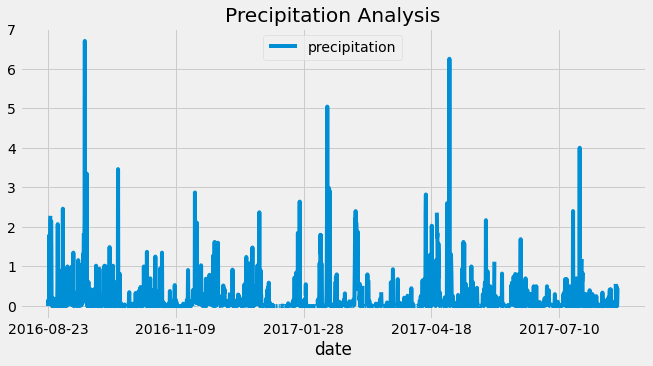

In [133]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation Analysis", figsize=(10,5))
plt.legend(loc='upper center')
plt.savefig("Images/precipitation.png")
plt.show()

In [134]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

In [136]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(measurement.station).distinct().count()
station_count

9

In [138]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [140]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(measurement.tobs), 
       func.max(measurement.tobs), 
       func.avg(measurement.tobs)]

min_max_avg_temp = session.query(*sel).\
    filter(measurement.station == "USC00519281").all()
min_max_avg_temp

[(54.0, 85.0, 71.66378066378067)]

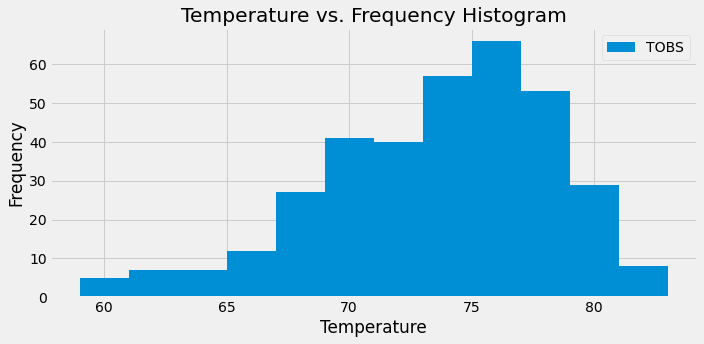

In [142]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs).\
    filter(measurement.date >= one_year_ago).\
    filter(measurement.station == "USC00519281").\
    order_by(measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["TOBS"])

# Plot the Results as a Histogram with `bins=12`
tobs_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/temperature_vs_frequency.png")
plt.show()

## Bonus Challenge Assignment

In [104]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
